<a href="https://colab.research.google.com/github/DiabeticRetinopathy114/114_DR/blob/main/224x224%20Gaussian%20Filtered/EfficientNet/EfficientNetB0.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path = kagglehub.dataset_download('sovitrath/diabetic-retinopathy-224x224-gaussian-filtered')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/export.pkl
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/f481f76a6b75.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/abdb365cacbc.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/33ffddea8c6e.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/059bc89df7f4.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/278aa860dffd.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/d66b6f333dc7.png
/kaggle/i

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from glob import glob
import albumentations as A
from collections import Counter
import warnings
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedShuffleSplit
#from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
warnings.filterwarnings('ignore')
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

class Config:
    IMG_SIZE = 224
    BATCH_SIZE = 16
    EPOCHS = 150
    LEARNING_RATE = 0.001
    PATIENCE = 10
    MIN_LR = 1e-8
    WEIGHT_DECAY = 1e-4
    CLASS_NAMES = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
    NUM_CLASSES = len(CLASS_NAMES)
    DATA_PATH = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
    MIN_SAMPLES_PER_CLASS = 800
    MAX_SAMPLES_PER_CLASS = 2000

class CustomAdamW(tf.keras.optimizers.Adam):
    def __init__(self, weight_decay=1e-4, **kwargs):
        super().__init__(**kwargs)
        self.weight_decay = weight_decay

    def _resource_apply_dense(self, grad, var, apply_state=None):
        if self.weight_decay:
            grad += self.weight_decay * var
        return super()._resource_apply_dense(grad, var, apply_state)

class AdvancedAugmentation:
    @staticmethod
    def get_train_augmentation():
        return A.Compose([
            A.HorizontalFlip(p=0.4),
            A.VerticalFlip(p=0.2),
            A.Rotate(limit=15, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
            A.CLAHE(clip_limit=2.0, p=0.5),
            A.Lambda(image=lambda x, **kwargs: preprocess_input(x))
        ])

    @staticmethod
    def get_val_augmentation():
        return A.Compose([
            A.Lambda(image=lambda x, **kwargs: preprocess_input(x))
        ])

class EnhancedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size, augmentation=None, shuffle=True, class_mode='sparse'):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.class_mode = class_mode
        self.input_shape = (self.img_size, self.img_size, 3)
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()
        # 移除 image_cache 以避免記憶體問題

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.image_paths[i] for i in indices]
        batch_labels = [self.labels[i] for i in indices]
        X, y = self._generate_data(batch_paths, batch_labels)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _load_image(self, path):
        image = cv2.imread(path)
        if image is None:
            return np.zeros((self.img_size, self.img_size, 3), dtype=np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return cv2.resize(image, (self.img_size, self.img_size))

    def _generate_data(self, batch_paths, batch_labels):
        actual_batch_size = len(batch_paths)
        X = np.empty((actual_batch_size, *self.input_shape), dtype=np.float32)

        # 自動偵測 label shape
        label_shape = np.shape(batch_labels[0])
        y = np.empty((actual_batch_size, *label_shape), dtype=np.float32)

        for i, (path, label) in enumerate(zip(batch_paths, batch_labels)):
            image = cv2.imread(path)
            if image is None:
                image = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (self.img_size, self.img_size))

            if self.augmentation:
                try:
                    augmented = self.augmentation(image=image)
                    image = augmented['image']
                except Exception as e:
                    print(f"資料增強錯誤: {e}")
                    image = preprocess_input(image.astype(np.float32))

            X[i] = image
            y[i] = label  # 直接指派 one-hot label

        return X, y


In [ ]:
# === Dataset Loading ===
def load_dataset(data_path):
    image_paths, labels = [], []
    for idx, cls in enumerate(Config.CLASS_NAMES):
        cls_path = os.path.join(data_path, cls)
        if os.path.exists(cls_path):
            images = glob(os.path.join(cls_path, '*'))
            image_paths.extend(images)
            labels.extend([idx] * len(images))

    image_paths, labels = np.array(image_paths), np.array(labels)
    from collections import defaultdict
    class_counts = defaultdict(list)
    for i, lbl in enumerate(labels):
        class_counts[lbl].append(image_paths[i])

    balanced_paths, balanced_labels = [], []
    for lbl, paths in class_counts.items():
        paths = np.array(paths)
        count = len(paths)
        target = min(max(Config.MIN_SAMPLES_PER_CLASS, count), Config.MAX_SAMPLES_PER_CLASS)
        if count < target:
            extra = np.random.choice(paths, size=(target - count), replace=True)
            paths = np.concatenate([paths, extra])
        else:
            paths = np.random.choice(paths, size=target, replace=False)
        balanced_paths.extend(paths)
        balanced_labels.extend([lbl] * target)

    balanced_paths, balanced_labels = np.array(balanced_paths), np.array(balanced_labels)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42) #測試集 (15%)
    for remain_idx, test_idx in sss1.split(balanced_paths, balanced_labels):
        remain_paths, test_paths = balanced_paths[remain_idx], balanced_paths[test_idx]
        remain_labels, test_labels = balanced_labels[remain_idx], balanced_labels[test_idx]

        val_ratio = 0.15 / 0.85  # ≈ 0.1765
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=42)
        for train_idx, val_idx in sss2.split(remain_paths, remain_labels):
            train_paths, val_paths = remain_paths[train_idx], remain_paths[val_idx]
            train_labels, val_labels = remain_labels[train_idx], remain_labels[val_idx]
             # 印出各資料集類別數量檢查
    from collections import Counter
    print("Train label distribution:", Counter(train_labels))
    print("Val label distribution:", Counter(val_labels))
    print("Test label distribution:", Counter(test_labels))

    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)

In [ ]:
def quick_balance_report(data_path):
    """快速查看資料平衡結果"""
    print("資料平衡快速報告")
    print("=" * 50)

    # 載入並統計原始資料
    for idx, cls in enumerate(Config.CLASS_NAMES):
        cls_path = os.path.join(data_path, cls)
        if os.path.exists(cls_path):
            images = glob(os.path.join(cls_path, '*'))
            count = len(images)
            target = min(max(Config.MIN_SAMPLES_PER_CLASS, count), Config.MAX_SAMPLES_PER_CLASS)

            if count < target:
                status = f"➕ 複製到 {target:,}"
            elif count > target:
                status = f"➖ 減少到 {target:,}"
            else:
                status = "保持不變"

            print(f"{cls:<15}: {count:>6,} → {status}")

In [ ]:
# 只想快速看看平衡效果
quick_balance_report(Config.DATA_PATH)

資料平衡快速報告
No_DR          :  1,805 → 保持不變
Mild           :    370 → ➕ 複製到 800
Moderate       :    999 → 保持不變
Severe         :    193 → ➕ 複製到 800
Proliferate_DR :    295 → ➕ 複製到 800


In [ ]:

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model

def create_model(input_shape, num_classes):
    # 載入 EfficientNetB0 backbone，不包含頂層
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True  # 若要先 freeze，這裡改為 False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)  # BatchNorm 在 Inference 模式
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)



In [ ]:
def main():
    # === 載入資料 ===
    (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = load_dataset(Config.DATA_PATH)

    # One-hot 編碼（因為 loss 使用 CategoricalCrossentropy）
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=Config.NUM_CLASSES)
    val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=Config.NUM_CLASSES)
    test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=Config.NUM_CLASSES)

    # === 資料增強器 ===
    train_aug = AdvancedAugmentation.get_train_augmentation()
    val_aug = AdvancedAugmentation.get_val_augmentation()

    # === 資料產生器 ===
    train_gen = EnhancedDataGenerator(train_paths, train_labels, Config.BATCH_SIZE, Config.IMG_SIZE, train_aug)
    val_gen = EnhancedDataGenerator(val_paths, val_labels, Config.BATCH_SIZE, Config.IMG_SIZE, val_aug)
    test_gen = EnhancedDataGenerator(test_paths, test_labels, Config.BATCH_SIZE, Config.IMG_SIZE, val_aug)

    # === 建立模型 ===
    model = create_model((Config.IMG_SIZE, Config.IMG_SIZE, 3), Config.NUM_CLASSES)

    # === Warm-up 階段：只訓練上層分類器 ===
    model.get_layer('efficientnetb0').trainable = False
    model.compile(
        optimizer=CustomAdamW(learning_rate=1e-3, weight_decay=Config.WEIGHT_DECAY),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    print("Warm-up training (frozen base)...")
    history_warmup = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,
        callbacks=[
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
        ]
    )

    # === Fine-tuning 階段：解凍整個模型 ===
    model.get_layer('efficientnetb0').trainable = True
    model.compile(
        optimizer=CustomAdamW(learning_rate=1e-5, weight_decay=Config.WEIGHT_DECAY),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    print("Fine-tuning full model...")
    history_finetune = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=Config.EPOCHS,
        initial_epoch=5,  # 從第5 epoch接續
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=Config.MIN_LR),
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=Config.PATIENCE, restore_best_weights=True),
        ]
    )

    # 回傳模型與 history（可以選擇合併兩段 history）
    return model, (history_warmup, history_finetune)


In [ ]:
def merge_history(h1, h2):
    merged = {}
    for k in h1:
        merged[k] = h1[k] + h2[k]
    return merged
model, (h1, h2) = main()
history = merge_history(h1.history, h2.history)


Train label distribution: Counter({0: 1263, 2: 699, 3: 560, 4: 560, 1: 560})
Val label distribution: Counter({0: 271, 2: 150, 3: 120, 1: 120, 4: 120})
Test label distribution: Counter({0: 271, 2: 150, 4: 120, 1: 120, 3: 120})
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Warm-up training (frozen base)...
Epoch 1/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 70s 206ms/step - accuracy: 0.4751 - loss: 1.3961 - val_accuracy: 0.5378 - val_loss: 1.1276 - learning_rate: 0.0010
Epoch 2/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/step - accuracy: 0.5579 - loss: 1.1593 - val_accuracy: 0.6069 - val_loss: 1.0995 - learning_rate: 0.0010
Epoch 3/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.5883 - loss: 1.1392 - val_accuracy: 0.6312 - val_loss: 1.0950 - learning_rate: 0.0010
Epoch 4/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.6000 - loss: 1.1245 - val_accuracy: 0.6402 - val_loss: 1.0825 - learning_rate: 0.0010
Epoch 5/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - accuracy: 0.5999 

E0000 00:00:1753519088.025683      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753519088.211266      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753519088.645093      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753519088.849811      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753519089.196998      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

 77/228 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.3920 - loss: 1.6443

E0000 00:00:1753519124.807723      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753519124.992205      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753519125.409739      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753519125.614386      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753519125.959963      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

228/228 ━━━━━━━━━━━━━━━━━━━━ 152s 278ms/step - accuracy: 0.4261 - loss: 1.5679 - val_accuracy: 0.5851 - val_loss: 1.1979 - learning_rate: 1.0000e-05
Epoch 7/150
228/228 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - accuracy: 0.4995 - loss: 1.3897 - val_accuracy: 0.6005 - val_loss: 1.1676 - learning_rate: 1.0000e-05
Epoch 8/150
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.5308 - loss: 1.2770 - val_accuracy: 0.6095 - val_loss: 1.1560 - learning_rate: 1.0000e-05
Epoch 9/150
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.5548 - loss: 1.2312 - val_accuracy: 0.6236 - val_loss: 1.1126 - learning_rate: 1.0000e-05
Epoch 10/150
228/228 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - accuracy: 0.5503 - loss: 1.2112 - val_accuracy: 0.6287 - val_loss: 1.0703 - learning_rate: 1.0000e-05
Epoch 11/150
228/228 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - accuracy: 0.5825 - loss: 1.1657 - val_accuracy: 0.6415 - val_loss: 1.0603 - learning_rate: 1.0000e-05
Epoch 12/150
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 107

In [ ]:
def plot_training_history(history):
    """繪製訓練歷史圖表"""
    plt.figure(figsize=(12, 5))

    # Loss 折線圖
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy 折線圖
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

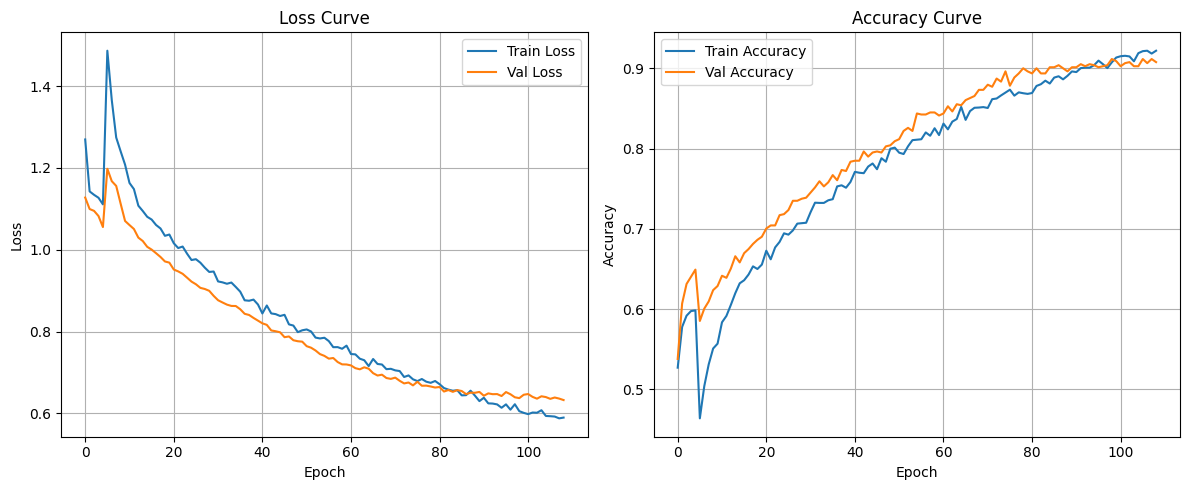

In [ ]:
plot_training_history(history)

Train label distribution: Counter({0: 1263, 2: 699, 3: 560, 4: 560, 1: 560})
Val label distribution: Counter({0: 271, 2: 150, 3: 120, 1: 120, 4: 120})
Test label distribution: Counter({0: 271, 2: 150, 4: 120, 1: 120, 3: 120})
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step

 Classification Report (on Test Set):

                precision    recall  f1-score   support

         No_DR       0.98      0.99      0.98       271
          Mild       0.92      0.92      0.92       120
      Moderate       0.92      0.90      0.91       150
        Severe       0.90      0.95      0.93       120
Proliferate_DR       0.97      0.95      0.96       120

      accuracy                           0.95       781
     macro avg       0.94      0.94      0.94       781
  weighted avg       0.95      0.95      0.95       781



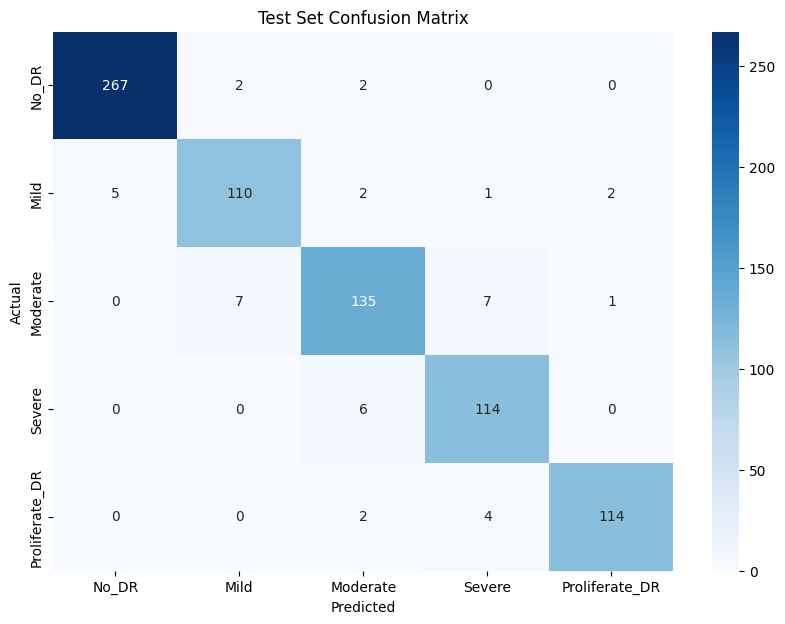

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 取得 test set
_, _, (test_paths, test_labels) = load_dataset(Config.DATA_PATH)

# 使用 validation 的增強方式（測試集不可用隨機變化）
test_aug = AdvancedAugmentation.get_val_augmentation()

# 建立 test generator
test_gen = EnhancedDataGenerator(test_paths, test_labels, Config.BATCH_SIZE, Config.IMG_SIZE, test_aug, shuffle=False)

# 預測機率
y_probs = model.predict(test_gen, verbose=1)

# 轉為類別預測
y_pred = np.argmax(y_probs, axis=1)
y_true = test_labels
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n Classification Report (on Test Set):\n")
print(classification_report(y_true, y_pred, target_names=Config.CLASS_NAMES))

# 混淆矩陣
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=Config.CLASS_NAMES,
            yticklabels=Config.CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix")
plt.show()

In [ ]:
#model.save('model_ResNet50.h5')